In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.optimize import curve_fit

from uncertainties import *
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import uncertainties.umath
import uncertainties

#definitions of the constants
capacitor_distance=0.006 #m
viscosity_air=1.81e-5 #Ns/m^2
density_oil=875 #kg/m^3
density_air=1.29 #kg/m^3
step_value=0.00005 #m
g=9.81 #m/s^2

In [2]:
sns.set_theme(style="ticks")
sns.set_context("talk")

In [3]:
#get data
sinksteig_data=pd.read_csv("Milikan_sinkSteig.csv", header=2)
#extract first 5 test measurements for method
sinksteig_test =sinksteig_data.head(5)
sinksteig_test

,U/V,U_err/V,t1/s,t1_err/s,t2/s,t2_err/s,scale-steps,scale-steps_err
0,504,1,6.122,0.01,3.281,0.01,3,1.732051
1,512,1,6.634,0.01,2.450,0.01,3,1.732051
2,511,1,4.119,0.01,3.400,0.01,3,1.732051
3,511,1,2.525,0.01,0.862,0.01,3,1.732051
4,523,1,2.881,0.01,2.368,0.01,3,1.732051


In [4]:
schweben_data=pd.read_csv("Milikan_Schweben.csv")
schweben_data

,U/V,U_err/V,t/s,t_err/s,s/Skalen,s_err
0,225,1,6.070,0.01,5,2.236068
1,138,1,5.281,0.01,3,1.732051
2,113,1,6.591,0.01,3,1.732051
3,175,1,3.573,0.01,3,1.732051
4,56,1,4.193,0.01,3,1.732051


Assume the droplet is $\textbf{floating}$. Hence we have no friction of air. Thus we have:
$Q=\frac{(\rho_{Oil}-\rho_{Air}) g d}{U} \frac{4\pi r^3}{3}$
But fo that formula we also need the radius of the droplet, that is beeing calculated after the following formula:
$r=\sqrt{\frac{9 \eta s}{2 g t (\rho_{Oil}-\rho_{Air})}}$

[2.344243896943926e-19+/-1.5726117964929619e-19
 2.188980469339739e-19+/-1.895789252353322e-19
 1.9172988570999833e-19+/-1.6605219387527945e-19
 3.101756145302649e-19+/-2.6862896543569227e-19
 7.624649841734001e-19+/-6.604600363784179e-19]
(2.0+/-0.7)e-19


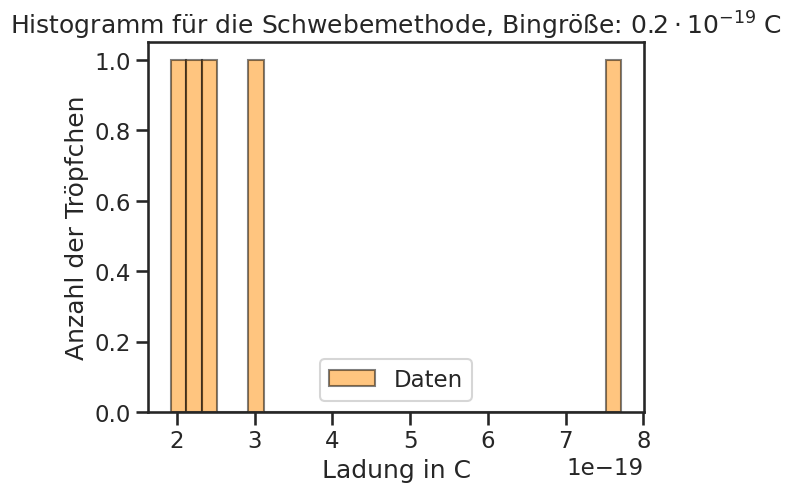

In [5]:
##testing floating method
#defining data for steps and time
s=[]
for i in range(len(schweben_data["s/Skalen"])):
    s.append(ufloat(schweben_data["s/Skalen"][i], schweben_data["s_err"][i]))
s=np.array(s)*step_value
t=[]
for i in range(len(schweben_data["t/s"])):
    t.append(ufloat(schweben_data["t/s"][i], schweben_data["t_err/s"][i]))
t=np.array(t)
U=[]
for i in range(len(schweben_data["U/V"])):
    U.append(ufloat(schweben_data["U/V"][i], schweben_data["U_err/V"][i]))
U=np.array(U)

#r squared
r2=9*s*viscosity_air/(2*g*t*(density_oil-density_air))

#Calculating the charge
Q=(density_oil-density_air)*4/3*np.pi*r2**(3/2)*g*capacitor_distance/U
print(Q)

#plotting
plt.hist([Q[i].n for i in range(len(Q))], color="darkorange", label="Daten", edgecolor="black",
         bins=np.arange(min([Q[i].n for i in range(len(Q))]), max([Q[i].n for i in range(len(Q))]) + 0.2e-19, 0.2e-19),
         alpha=0.5)
plt.xlabel("Ladung in C")
plt.ylabel("Anzahl der Tröpfchen")
plt.title(r"Histogramm für die Schwebemethode, Bingröße: $0.2 \cdot 10^{-19}$ C")
plt.legend()
Q_mean=(Q[0]+Q[1]+Q[2]+Q[3]/2+Q[4]/4)/5
print(Q_mean)
plt.savefig("Schweben_plot.png", dpi=500, bbox_inches="tight")
plt.show()

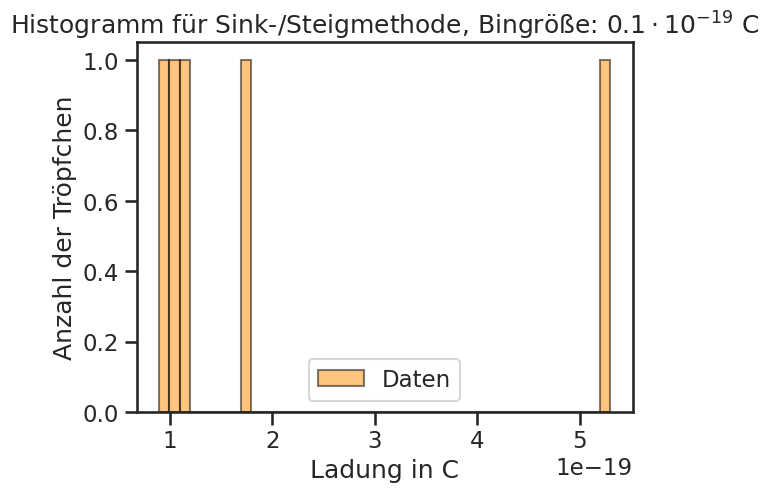

(1.8+/-1.0)e-19


In [6]:
##test ascend/descend method
#defining the data
s=[]
for i in range(len(sinksteig_test["scale-steps"])):
    s.append(ufloat(sinksteig_test["scale-steps"][i], sinksteig_test["scale-steps_err"][i]))
s=np.array(s)*step_value
t1=[]
for i in range(len(sinksteig_test["t1/s"])):
    t1.append(ufloat(sinksteig_test["t1/s"][i], sinksteig_test["t1_err/s"][i]))
t1=np.array(t1)
t2=[]
for i in range(len(sinksteig_test["t2/s"])):
    t2.append(ufloat(sinksteig_test["t2/s"][i], sinksteig_test["t2_err/s"][i]))
t2=np.array(t2)
U=[]
for i in range(len(sinksteig_test["U/V"])):
    U.append(ufloat(sinksteig_test["U/V"][i], sinksteig_test["U_err/V"][i]))
U=np.array(U)

#calculating the velocities
v1=s/t1
v2=s/t2

r2=9*s*viscosity_air/(2*g*t1*(density_oil-density_air))
r=r2**(1/2)
Q=capacitor_distance/U*((density_oil-density_oil)*4/3*np.pi*r**3*g+6*np.pi*r*viscosity_air*v2)
plt.hist([Q[i].n for i in range(len(Q))], color="darkorange", label="Daten", edgecolor="black",
         bins=np.arange(min([Q[i].n for i in range(len(Q))]), max([Q[i].n for i in range(len(Q))]) + 0.1e-19, 0.1e-19),
         alpha=0.5)
plt.xlabel("Ladung in C")
plt.ylabel("Anzahl der Tröpfchen")
plt.title(r"Histogramm für Sink-/Steigmethode, Bingröße: $0.1 \cdot 10^{-19}$ C")
plt.legend()
plt.savefig("Sink-steig_erste5plot.png", dpi=500, bbox_inches="tight")
plt.show()
Q_mean=(Q[0]+Q[1]+Q[2]+Q[3]+Q[4]/3)/5
print(Q_mean)

Calculation of the elementary charge through ascend/descend method. 

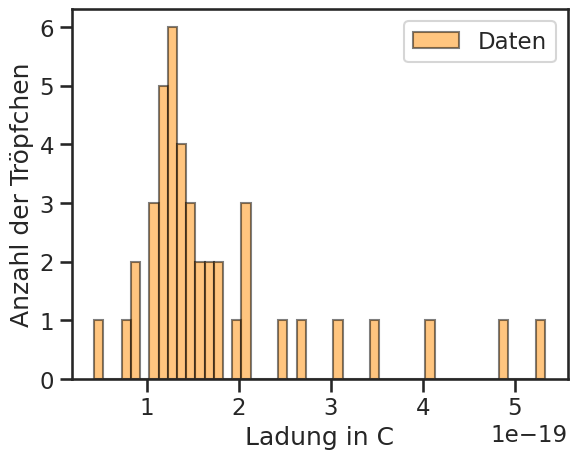

In [7]:
#defining the data
s=[]
for i in range(len(sinksteig_data["scale-steps"])):
    s.append(ufloat(sinksteig_data["scale-steps"][i], sinksteig_data["scale-steps_err"][i]))
s=np.array(s)*step_value
t1=[]
for i in range(len(sinksteig_data["t1/s"])):
    t1.append(ufloat(sinksteig_data["t1/s"][i], sinksteig_data["t1_err/s"][i]))
t1=np.array(t1)
t2=[]
for i in range(len(sinksteig_data["t2/s"])):
    t2.append(ufloat(sinksteig_data["t2/s"][i], sinksteig_data["t2_err/s"][i]))
t2=np.array(t2)
U=[]
for i in range(len(sinksteig_data["U/V"])):
    U.append(ufloat(sinksteig_data["U/V"][i], sinksteig_data["U_err/V"][i]))
U=np.array(U)

#calculating the velocities
v1=s/t1
v2=s/t2

r2=9*s*viscosity_air/(2*g*t1*(density_oil-density_air))
r=r2**(1/2)
Q=capacitor_distance/U*((density_oil-density_oil)*4/3*np.pi*r**3*g+6*np.pi*r*viscosity_air*v2)
plt.hist([Q[i].n for i in range(len(Q))], color="darkorange", label="Daten", edgecolor="black",
         bins=np.arange(min([Q[i].n for i in range(len(Q))]), max([Q[i].n for i in range(len(Q))]) + 0.1e-19, 0.1e-19),
         alpha=0.5)
plt.xlabel("Ladung in C")
plt.ylabel("Anzahl der Tröpfchen")
plt.legend()
plt.savefig("Sink-steig_reinedaten.png", dpi=500, bbox_inches="tight")
plt.show()

Three groups of charge were chosen with knowledge about the possible distributions.

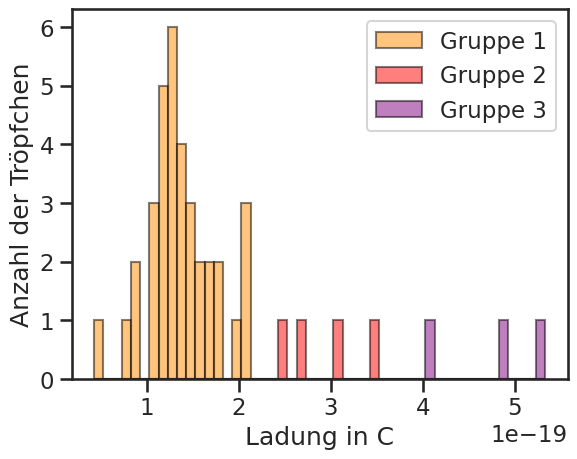

In [8]:
#use Q without errors
Q_ = np.ones(len(Q))
for i in range(len(Q)): 
    Q_[i] = Q[i].n

#determine datapoints in a group and extract them for each group
e1_ind = np.where((Q_ >= 0) & (Q_ < 2.2 * 10**(-19)))
Q_e1 = Q_[e1_ind]
e2_ind = np.where((Q_ >= 2.2 * 10**(-19)) & (Q_ < 3.8 * 10**(-19)))
Q_e2 = Q_[e2_ind]
e3_ind = np.where((Q_ >= 3.8 * 10**(-19)) & (Q_ < 5.5 * 10**(-19)))
Q_e3 = Q_[e3_ind]

plt.hist(Q_e1, color="darkorange", label="Gruppe 1", edgecolor="black",
         bins=np.arange(min(Q_), max(Q_) + 0.1e-19, 0.1e-19),
         alpha=0.5)
plt.hist(Q_e2, color="red", label="Gruppe 2", edgecolor="black",
         bins=np.arange(min(Q_), max(Q_) + 0.1e-19, 0.1e-19),
         alpha=0.5)
plt.hist(Q_e3, color="purple", label="Gruppe 3", edgecolor="black",
         bins=np.arange(min(Q_), max(Q_) + 0.1e-19, 0.1e-19),
         alpha=0.5)
plt.xlabel("Ladung in C")
plt.ylabel("Anzahl der Tröpfchen")
plt.legend()
plt.savefig("Sink-steig_daten_gruppiert.png", dpi=500, bbox_inches="tight")
plt.show()

avg/std: (1.4+/-0.4)e-19 (2.9+/-0.4)e-19 (4.7+/-0.5)e-19


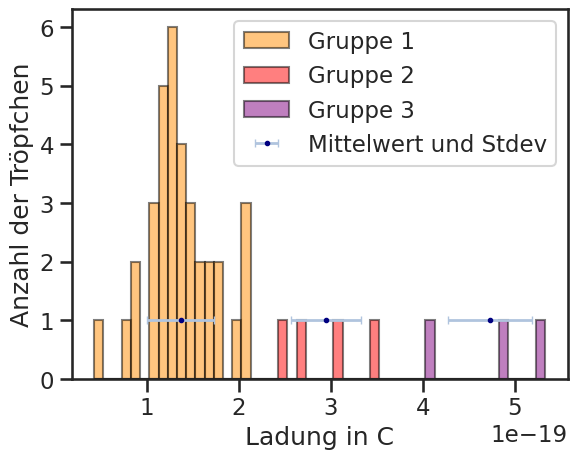

In [9]:
#compute averages and standard deviations for each group
q1 = np.average(Q_e1)
q1_e = np.std(Q_e1)
q_e1 = ufloat(q1, q1_e)

q2 = np.average(Q_e2)
q2_e = np.std(Q_e2)
q_e2 = ufloat(q2, q2_e)

q3 = np.average(Q_e3)
q3_e = np.std(Q_e3)
q_e3 = ufloat(q3, q3_e)

print('avg/std:',q_e1,q_e2,q_e3)

plt.hist(Q_e1, color="darkorange", label="Gruppe 1", edgecolor="black",
         bins=np.arange(min(Q_), max(Q_) + 0.1e-19, 0.1e-19),
         alpha=0.5)
plt.hist(Q_e2, color="red", label="Gruppe 2", edgecolor="black",
         bins=np.arange(min(Q_), max(Q_) + 0.1e-19, 0.1e-19),
         alpha=0.5)
plt.hist(Q_e3, color="purple", label="Gruppe 3", edgecolor="black",
         bins=np.arange(min(Q_), max(Q_) + 0.1e-19, 0.1e-19),
         alpha=0.5)
plt.errorbar(x = np.array([q1,q2,q3]), xerr = np.array([q1_e,q2_e,q3_e]), y = np.array([1,1,1]), 
             markersize=6, fmt=".",color="navy", ecolor="lightsteelblue", elinewidth=2, capsize=3, label="Mittelwert und Stdev")
plt.xlabel("Ladung in C")
plt.ylabel("Anzahl der Tröpfchen")
plt.legend()
plt.savefig("Sink-steig_daten_gruppiert_mitFehler.png", dpi=500, bbox_inches="tight")
plt.show()            

b1: 3.696911752265524e-05
Q_e1 Fit: (1.23+/-0.34)e-19
Q_e1 Calc: (1.25+/-0.34)e-19


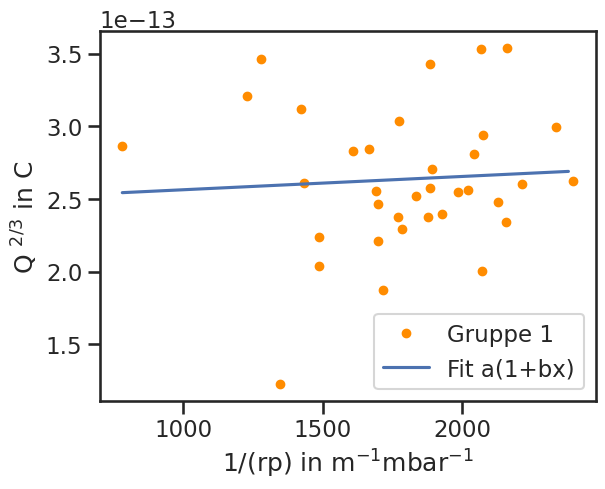

In [10]:
##find correction for e1
#find b and y0
def linfunc(x,a,b):
    return a * (1+b*x) # a = y0**(2/3)
p = 1016 #pressure of lab

Q_f = Q_e1**(2/3)
r_e1 = r[e1_ind]
x_e1 = np.ones(len(r_e1))
for i in range(len(r_e1)): 
    x_e1[i] = (r_e1[i].n*1000)**(-1)
vars, covmat = sp.optimize.curve_fit(linfunc,x_e1, Q_f,)
Q_e1fit = ufloat(vars[0], np.sqrt(covmat[0][0]))**(3/2)
print('b1:', vars[1])
print('Q_e1 Fit:', Q_e1fit)
#corrected Q1
b = vars[1]
re1 = np.average([r_e1[i].n for i in range(len(r_e1))])
x_e1avg = (re1*p)**(-1)
K = 1/((1+b*x_e1avg)**(3/2))
q1_k = q_e1*K
print('Q_e1 Calc:', q1_k)
plt.plot(x_e1,Q_f,'o', ms = 6, color = 'darkorange', label = 'Gruppe 1')
a = np.arange(min(x_e1), max(x_e1), 100)
plt.plot(a, linfunc(a,vars[0], vars[1]), label = 'Fit a(1+bx)')
plt.xlabel(r"1/(rp) in m$^{-1}$mbar$^{-1}$")
plt.ylabel(r"Q $^{2/3}$ in C")
plt.legend()
plt.savefig("Fit_Gruppe1.png", dpi=500, bbox_inches="tight")
plt.show()


b2: -1.9892729331894606e-06
Q_e2 Fit: (3.0+/-1.0)e-19
Q_e2 Calc: (3.0+/-0.4)e-19


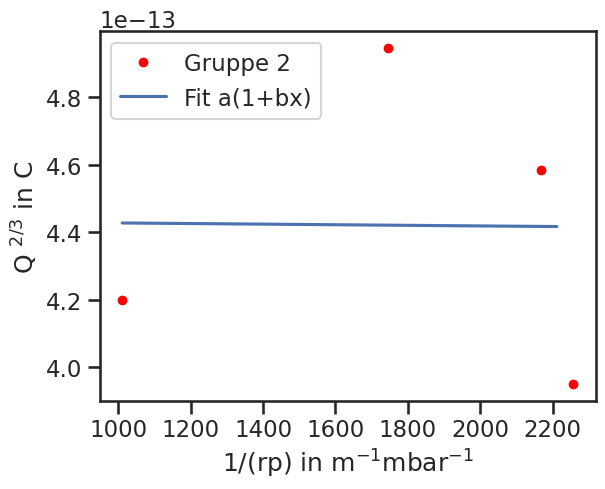

In [11]:
##find correction for e2
#find b and y0
def linfunc(x,a,b):
    return a * (1+b*x) # a = y0**(2/3)
p = 1016 #pressure of lab
#correction fit for only group 2
Q_f = Q_e2**(2/3)
r_e2 = r[e2_ind]
x_e2 = np.ones(len(r_e2))
for i in range(len(r_e2)): 
    x_e2[i] = (r_e2[i].n*1000)**(-1)
vars, covmat = sp.optimize.curve_fit(linfunc,x_e2, Q_f,)
Q_e2fit = ufloat(vars[0], np.sqrt(covmat[0][0]))**(3/2)
print('b2:', vars[1])
print('Q_e2 Fit:', Q_e2fit)
#corrected Q2
b = vars[1]
re2 = np.average([r_e2[i].n for i in range(len(r_e2))])
x_e2avg = (re2*p)**(-1)
K = 1/((1+b*x_e2avg)**(3/2))
q2_k = q_e2*K
print('Q_e2 Calc:', q2_k)
plt.plot(x_e2,Q_f,'o', ms = 6, color = 'red', label = 'Gruppe 2')
a = np.arange(min(x_e2), max(x_e2), 100)
plt.plot(a, linfunc(a,vars[0], vars[1]), label = 'Fit a(1+bx)')
plt.xlabel(r"1/(rp) in m$^{-1}$mbar$^{-1}$")
plt.ylabel(r"Q $^{2/3}$ in C")
plt.legend()
plt.savefig("Fit_Gruppe2.png", dpi=500, bbox_inches="tight")
plt.show()

b3: -7.6572434901216e-06
Q_e3 Fit: (4.8+/-3.5)e-19
Q_e3 Calc: (4.8+/-0.5)e-19


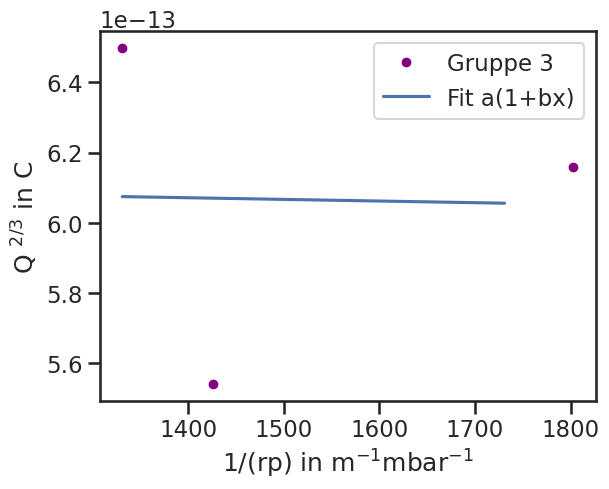

In [12]:
##find correction for e3
#find b and y0
def linfunc(x,a,b):
    return a * (1+b*x) # a = y0**(2/3)
p = 1016 #pressure of lab
#correction fit for only group 3
Q_f = Q_e3**(2/3)
r_e3 = r[e3_ind]
x_e3 = np.ones(len(r_e3))
for i in range(len(r_e3)): 
    x_e3[i] = (r_e3[i].n*1000)**(-1)
vars, covmat = sp.optimize.curve_fit(linfunc,x_e3, Q_f,)
Q_e3fit = ufloat(vars[0], np.sqrt(covmat[0][0]))**(3/2)
print('b3:', vars[1])
print('Q_e3 Fit:', Q_e3fit)
#corrected Q3
b = vars[1]
re3 = np.average([r_e3[i].n for i in range(len(r_e3))])
x_e3avg = (re3*p)**(-1)
K = 1/((1+b*x_e3avg)**(3/2))
q3_k = q_e3*K
print('Q_e3 Calc:', q3_k)
plt.plot(x_e3,Q_f,'o', ms = 6, color = 'purple', label = 'Gruppe 3')
a = np.arange(min(x_e3), max(x_e3), 100)
plt.plot(a, linfunc(a,vars[0], vars[1]), label = 'Fit a(1+bx)')
plt.xlabel(r"1/(rp) in m$^{-1}$mbar$^{-1}$")
plt.ylabel(r"Q $^{2/3}$ in C")
plt.legend()
plt.savefig("Fit_Gruppe3.png", dpi=500, bbox_inches="tight")
plt.show()

b_avg: -0.00010723885827268027
Q_avg Fit: (2.3+/-0.8)e-19
Q_e1 Calc: (1.25+/-0.34)e-19
Q_e3 Calc: (3.0+/-0.4)e-19
Q_e3 Calc: (4.8+/-0.5)e-19


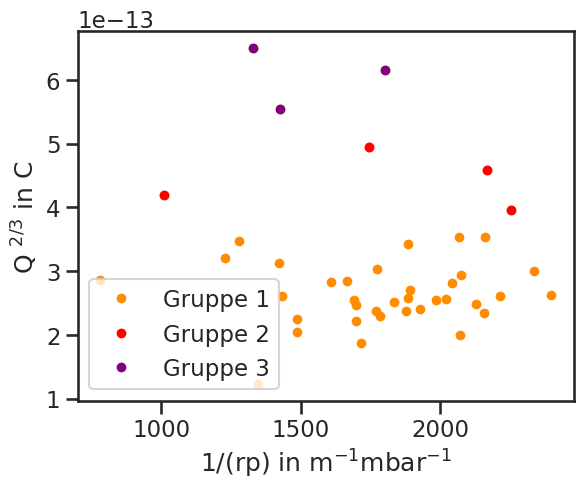

In [13]:
##find correction for all with total data
#find b and y0
def linfunc(x,a,b):
    return a * (1+b*x) # a = y0**(2/3)
p = 1016 #pressure of lab
Q_f = Q_**(2/3)
r_ = r
x_ = np.ones(len(r_))
for i in range(len(r_)): 
    x_[i] = (r_[i].n*1000)**(-1)
vars, covmat = sp.optimize.curve_fit(linfunc,x_, Q_f,)
Q_fit = ufloat(vars[0], np.sqrt(covmat[0][0]))**(3/2)
print('b_avg:', vars[1])
print('Q_avg Fit:', Q_fit)
#corrected q values with this total fit
b = vars[1]
#for Q_e1
re1 = np.average([r_e1[i].n for i in range(len(r_e1))])
x_e1a = (re1*p)**(-1)
K = 1/((1+b*x_e1avg)**(3/2))
q1_ka = q_e1*K
print('Q_e1 Calc:', q1_k)
#for Q_e2
re2 = np.average([r_e2[i].n for i in range(len(r_e2))])
x_e2avg = (re2*p)**(-1)
K = 1/((1+b*x_e2avg)**(3/2))
q2_ka = q_e2*K
print('Q_e3 Calc:', q2_k)
#for Q_e3
re3 = np.average([r_e3[i].n for i in range(len(r_e3))])
x_e3avg = (re3*p)**(-1)
K = 1/((1+b*x_e3avg)**(3/2))
q3_ka = q_e3*K
print('Q_e3 Calc:', q3_k)
plt.plot(x_,Q_f,'o', ms = 6, color = 'darkorange', label = 'Gruppe 1')
plt.plot(x_e2,Q_e2**(2/3),'o', ms = 6, color = 'red', label = 'Gruppe 2')
plt.plot(x_e3,Q_e3**(2/3),'o', ms = 6, color = 'purple', label = 'Gruppe 3')
a = np.arange(min(x_), max(x_), 100)
#plt.plot(a, linfunc(a,vars[0], vars[1]), label = 'Fit a(1+bx)')
plt.xlabel(r"1/(rp) in m$^{-1}$mbar$^{-1}$")
plt.ylabel(r"Q $^{2/3}$ in C")
plt.legend()
plt.savefig("Fit_GruppenZusammen.png", dpi=500, bbox_inches="tight")
plt.show()

In [46]:
q_e_g = (q_e1 + q_e2/2 + q_e3/3)/3 
print(q_e_g, '|qe avg, no corr.' )
q_e_k2 = (q1_k + q2_k/2 + q3_k/3)/3
print(q_e_k2, '|qe avg, with corr.')
q_e_k = (q2_k/2 + q3_k/3)/2
print(q_e_k, '|qe avg, with corr., only group 2,3')
q_e_ka = (q1_ka + q2_ka/2 + q3_ka/3)/3
print(q_e_ka, '|qe avg, with corr. over all datapoints')

(1.47+/-0.15)e-19 |qe avg, no corr.
(1.45+/-0.14)e-19 |qe avg, with corr.
(1.54+/-0.12)e-19 |qe avg, with corr., only group 2,3
(1.95+/-0.20)e-19 |qe avg, with corr. over all datapoints
